In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize']=[12,8]

matplotlib.rc('font',family='NanumGothic')
df_order=pd.read_csv("./log_order_sheet_001.csv")


/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  
/home/piai/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df_order['주문일시(월별)']=df_order['주문일시'].str.slice(start=0,stop=10)
df_split=df_order[['총수량','주문일시(월별)']]

In [3]:
df_split['주문일시(월별)']=pd.to_datetime(df_split['주문일시(월별)'])

/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46749 entries, 0 to 46748
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   총수량       46749 non-null  int64         
 1   주문일시(월별)  46749 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 730.6 KB


In [5]:
df_split

,총수량,주문일시(월별)
0,300,2018-12-27
1,2000,2018-12-29
2,200,2018-12-30
3,300,2018-12-31
4,400,2018-12-31
...,...,...
46744,200,2017-12-29
46745,400,2017-12-29
46746,1500,2017-12-30
46747,400,2017-12-31


In [6]:
df_day=df_split.set_index("주문일시(월별)")

In [7]:
df_day=df_split.groupby(by=['주문일시(월별)']).sum().groupby(level=[0]).cumsum()

df_day

,총수량
주문일시(월별),
2017-01-01,1000
2017-01-15,100
2017-01-18,1000
2017-01-23,100
2017-02-02,400
...,...
2019-05-31,50909
2019-06-01,500
2019-06-02,2000


In [8]:
df_day_train=df_day[df_day.index<"2019-01-01"]
df_day_test=df_day[df_day.index>="2019-01-01"]
df_day_test.head()

,총수량
주문일시(월별),
2019-01-01,25800
2019-01-02,95267
2019-01-03,122804
2019-01-04,76708
2019-01-05,19408


/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


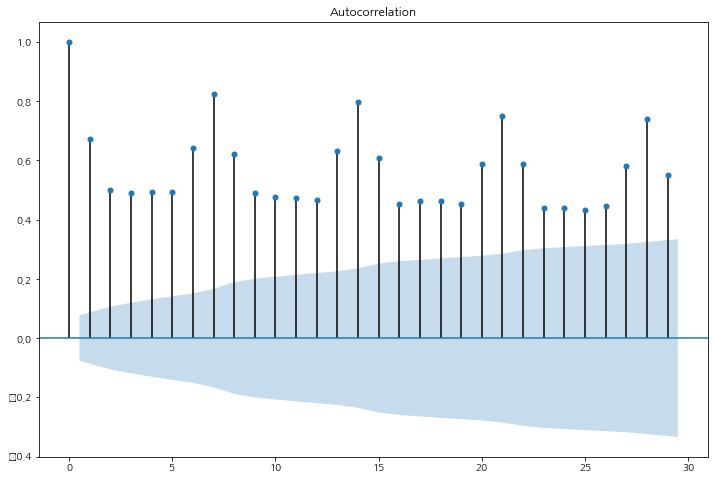

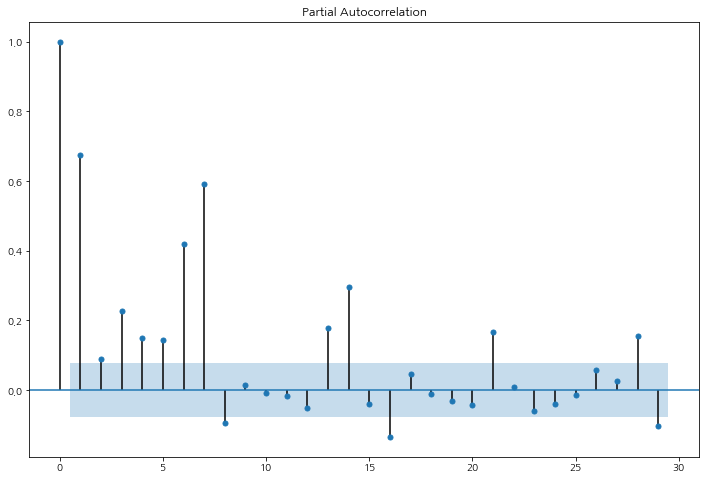

In [9]:
plot_acf(df_day_train)
plot_pacf(df_day_train)
plt.show()

In [10]:
#Train 데이터 이용, AR(1),I(2,차분),MA(0)인 ARIMA 모델
model=ARIMA(df_day_train,order=(1,2,0))
#데이터 적합
#trend:상수 포함 여부"nc"이면 상수 미포함,full_output:모든 출력결과 표시
result=model.fit(trend="nc",full_output=True)
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.총수량   No. Observations:                  650
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -7633.702
Method:                       css-mle   S.D. of innovations          30485.373
Date:                Tue, 21 Jul 2020   AIC                          15271.404
Time:                        16:29:08   BIC                          15280.358
Sample:                             2   HQIC                         15274.877
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D2.총수량    -0.4950      0.034    -14.541      0.000      -0.562      -0.428
                                    Roots                                    
                  Real          Imaginary      

/home/piai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/piai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


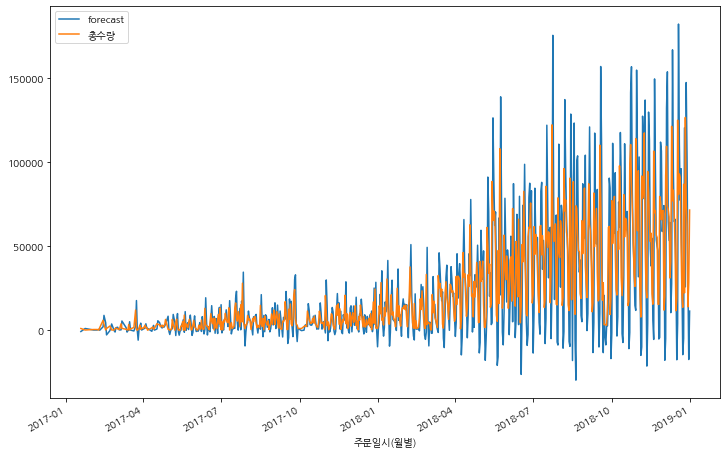

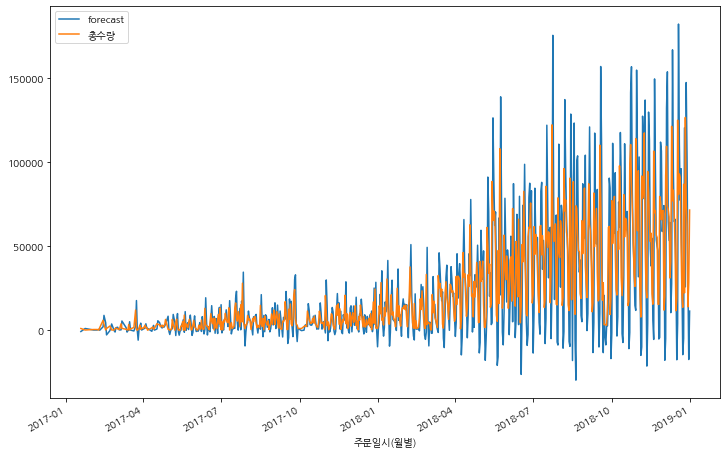

In [11]:
result.plot_predict()

In [12]:
# start_time=df_day_test.index.min()
# end_time=df_day_test.index.max()

# fig,ax=plt.subplots(figsize=(12,8))

# ax=df_day_train.plot(ax=ax)
# fig=result.plot_predict(start=start_time,end=end_time,ax=ax,plot_insample=False)

In [13]:
#df_day_test

In [14]:
#fig=result.predict(start=start_time,end=end_time,typ='levels')

In [15]:
#fig

# LSTM

In [16]:
# sc=MinMaxScaler()

# train_sc=sc.fit_transform(df_day_train)
# test_sc=sc.transform(df_day_test)

# train_sc

In [17]:
# train_sc_df = pd.DataFrame(train_sc, columns=['판매량'], index=df_day_train.index)
# test_sc_df = pd.DataFrame(test_sc, columns=['판매량'], index=df_day_test.index)
# train_sc_df.head()

In [63]:
for s in range(1, 12):
    df_day_train['shift_{}'.format(s)] = df_day_train['총수량'].shift(s)
    df_day_test['shift_{}'.format(s)] = df_day_test['총수량'].shift(s)



/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
df_day_train.head(24)

,총수량,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11
주문일시(월별),,,,,,,,,,,,
2017-01-01,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15,100,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-18,1000,100.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-23,100,1000.0,100.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-02,400,100.0,1000.0,100.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-06,400,400.0,100.0,1000.0,100.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-08,100,400.0,400.0,100.0,1000.0,100.0,1000.0,NaN,NaN,NaN,NaN,NaN
2017-02-09,1500,100.0,400.0,400.0,100.0,1000.0,100.0,1000.0,NaN,NaN,NaN,NaN
2017-02-13,5900,1500.0,100.0,400.0,400.0,100.0,1000.0,100.0,1000.0,NaN,NaN,NaN


In [65]:
X_train = df_day_train.dropna().drop('총수량', axis=1)
y_train = df_day_train.dropna()[['총수량']]

X_test = df_day_test.dropna().drop('총수량', axis=1)
y_test = df_day_test.dropna()[['총수량']]


X_train.head(10)


,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11
주문일시(월별),,,,,,,,,,,
2017-02-17,100.0,3500.0,5900.0,1500.0,100.0,400.0,400.0,100.0,1000.0,100.0,1000.0
2017-02-21,1000.0,100.0,3500.0,5900.0,1500.0,100.0,400.0,400.0,100.0,1000.0,100.0
2017-02-23,2501.0,1000.0,100.0,3500.0,5900.0,1500.0,100.0,400.0,400.0,100.0,1000.0
2017-02-26,100.0,2501.0,1000.0,100.0,3500.0,5900.0,1500.0,100.0,400.0,400.0,100.0
2017-02-27,100.0,100.0,2501.0,1000.0,100.0,3500.0,5900.0,1500.0,100.0,400.0,400.0
2017-02-28,1000.0,100.0,100.0,2501.0,1000.0,100.0,3500.0,5900.0,1500.0,100.0,400.0
2017-03-02,1200.0,1000.0,100.0,100.0,2501.0,1000.0,100.0,3500.0,5900.0,1500.0,100.0
2017-03-03,801.0,1200.0,1000.0,100.0,100.0,2501.0,1000.0,100.0,3500.0,5900.0,1500.0
2017-03-04,500.0,801.0,1200.0,1000.0,100.0,100.0,2501.0,1000.0,100.0,3500.0,5900.0


In [66]:
X_test.head(10)

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11
주문일시(월별),,,,,,,,,,,
2019-01-12,59763.0,63212.0,81708.0,75211.0,100204.0,47308.0,19408.0,76708.0,122804.0,95267.0,25800.0
2019-01-13,25500.0,59763.0,63212.0,81708.0,75211.0,100204.0,47308.0,19408.0,76708.0,122804.0,95267.0
2019-01-14,40104.0,25500.0,59763.0,63212.0,81708.0,75211.0,100204.0,47308.0,19408.0,76708.0,122804.0
2019-01-15,108815.0,40104.0,25500.0,59763.0,63212.0,81708.0,75211.0,100204.0,47308.0,19408.0,76708.0
2019-01-16,113212.0,108815.0,40104.0,25500.0,59763.0,63212.0,81708.0,75211.0,100204.0,47308.0,19408.0
2019-01-17,90915.0,113212.0,108815.0,40104.0,25500.0,59763.0,63212.0,81708.0,75211.0,100204.0,47308.0
2019-01-18,96601.0,90915.0,113212.0,108815.0,40104.0,25500.0,59763.0,63212.0,81708.0,75211.0,100204.0
2019-01-19,74200.0,96601.0,90915.0,113212.0,108815.0,40104.0,25500.0,59763.0,63212.0,81708.0,75211.0
2019-01-20,18204.0,74200.0,96601.0,90915.0,113212.0,108815.0,40104.0,25500.0,59763.0,63212.0,81708.0


In [67]:
print(type(X_train))
X_train = X_train.values
print(type(X_test))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(641, 11)
(641, 1)
(144, 11)
(144, 1)


In [68]:
X_test

array([[ 59763.,  63212.,  81708., ..., 122804.,  95267.,  25800.],
       [ 25500.,  59763.,  63212., ...,  76708., 122804.,  95267.],
       [ 40104.,  25500.,  59763., ...,  19408.,  76708., 122804.],
       ...,
       [   500.,  50909.,  72537., ...,  61904.,  73604., 100504.],
       [  2000.,    500.,  50909., ...,  16050.,  61904.,  73604.],
       [   300.,   2000.,    500., ...,  17000.,  16050.,  61904.]])

In [69]:
X_train

array([[1.0000e+02, 3.5000e+03, 5.9000e+03, ..., 1.0000e+03, 1.0000e+02,
        1.0000e+03],
       [1.0000e+03, 1.0000e+02, 3.5000e+03, ..., 1.0000e+02, 1.0000e+03,
        1.0000e+02],
       [2.5010e+03, 1.0000e+03, 1.0000e+02, ..., 4.0000e+02, 1.0000e+02,
        1.0000e+03],
       ...,
       [6.2672e+04, 7.6237e+04, 1.2677e+05, ..., 9.1112e+04, 9.3063e+04,
        8.0829e+04],
       [1.3878e+04, 6.2672e+04, 7.6237e+04, ..., 5.0802e+04, 9.1112e+04,
        9.3063e+04],
       [2.8263e+04, 1.3878e+04, 6.2672e+04, ..., 2.0606e+04, 5.0802e+04,
        9.1112e+04]])

In [70]:
X_train_t = X_train.reshape(X_train.shape[0], 11, 1)
X_test_t = X_test.reshape(X_test.shape[0], 11, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_test_t.shape)


최종 DATA
(641, 11, 1)
(144, 11, 1)


In [71]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(11, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [78]:

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30,  callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 0s 11ms/step - loss: 1333158400.0000
Epoch 2/100
22/22 [==============================] - 0s 12ms/step - loss: 1333140096.0000
Epoch 3/100
22/22 [==============================] - 0s 11ms/step - loss: 1333120256.0000
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 1333100672.0000
Epoch 5/100
22/22 [==============================] - 0s 11ms/step - loss: 1333080704.0000
Epoch 6/100
22/22 [==============================] - 0s 12ms/step - loss: 1333007104.0000
Epoch 7/100
22/22 [==============================] - 0s 11ms/step - loss: 1332969856.0000
Epoch 8/100
22/22 [==============================] - 0s 11ms/step - loss: 1332946048.0000
Epoch 9/100
22/22 [==============================] - 0s 12ms/step - loss: 1332923648.0000
Epoch 10/100
22/22 [==============================] - 0s 11ms/step - loss: 1332901248.0000
Epoch 11/100
22/22 [==============================] - 0s 12ms/step - loss: 1332879616.0000
Epoch 12

22/22 [==============================] - 0s 11ms/step - loss: 1331132544.0000
Epoch 92/100
22/22 [==============================] - 0s 11ms/step - loss: 1331111168.0000
Epoch 93/100
22/22 [==============================] - 0s 10ms/step - loss: 1331090048.0000
Epoch 94/100
22/22 [==============================] - 0s 11ms/step - loss: 1331068928.0000
Epoch 95/100
22/22 [==============================] - 0s 12ms/step - loss: 1331047296.0000
Epoch 96/100
22/22 [==============================] - 0s 13ms/step - loss: 1331026304.0000
Epoch 97/100
22/22 [==============================] - 0s 11ms/step - loss: 1331005056.0000
Epoch 98/100
22/22 [==============================] - 0s 11ms/step - loss: 1330983552.0000
Epoch 99/100
22/22 [==============================] - 0s 12ms/step - loss: 1330962816.0000
Epoch 100/100
22/22 [==============================] - 0s 12ms/step - loss: 1330940672.0000


In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.predict(X_test_t)

array([[111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],
       [111.39621],


In [58]:
X_test_t.shape

(144, 11, 1)